In [38]:
from google.oauth2 import service_account
from google.cloud import storage
import io
import nibabel as nib
import os
import pandas as pd
import tensorflow as tf
import gcsfs
import random
import re
from nilearn import image
import numpy as np
import time
import matplotlib.pyplot as plt

rel_path = '../data/'

In [39]:
#first create this file via IAM management on Google Cloud Platform
api_key = "deep-learning-255016-4350337ed6f4.json"
credentials = service_account.Credentials.from_service_account_file(api_key)
client = storage.Client(credentials=credentials, project="deep-learning")

fs = gcsfs.GCSFileSystem(token=api_key, project="deep-learning")
with fs.open('mri_data_bucket/ADNI_t1_list_with_fsstatus_20190111.csv') as f:
    df = pd.read_csv(f)
df.to_csv('labels.csv')

In [40]:
bucket_name = "mri_data_bucket"
bucket = client.get_bucket(bucket_name)
prefix = "data"
blobs = bucket.list_blobs(prefix=prefix)

file_names = [blob.name for blob in blobs]

In [41]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [42]:
labels=df[['Subject','T1.SERIESID','Group']].copy()

def labels_slice(labels, groups):
    
    filter_ = pd.Series(np.repeat(0, labels.shape[0]), index=labels.index)
    for group in groups:
        group_filter = (labels.Group == group)
        filter_ = filter_ | group_filter
    labels = labels[pd.Series(filter_)]
    return labels

labels = labels_slice(labels, ['CN', 'AD', 'EMCI', 'LMCI', 'MCI'])



labels['new_ind']=labels['Subject']+"_"+labels['T1.SERIESID'].astype(str)
labels.loc[labels.Group == 'CN','Group']=0
labels.loc[labels.Group == 'AD','Group']=1
labels.loc[labels.Group == 'EMCI','Group']=2
labels.loc[labels.Group == 'LMCI','Group']=3
labels.loc[labels.Group == 'MCI','Group']=4
labels = labels.set_index('new_ind')
labels=labels.drop(columns=['Subject','T1.SERIESID'])

In [43]:
print("Number of images: ", len(file_names))
print("Number of images without label: ", len(file_names) - labels.shape[0])
print("Labels: ", labels.shape[0])

Number of images:  10435
Number of images without label:  787
Labels:  9648


In [44]:
pattern1 = re.compile(r'S\d+')
pattern2 = re.compile(r'\d+_S_\d+')

In [45]:
def download(file_names, path='../data'):
    """
    run only 1 time to transfer the data from the bucket to the path
    transfers only data with label
    """
    if not os.path.exists(path):
        os.makedirs(path)
    count=0
    with_label = []
    for filename in file_names:
        filename=filename[5:]
        try:
            series_id = re.search(pattern1, filename).group(0)[1:]
            subject = re.search(pattern2,filename).group(0)
            ind=subject+"_"+series_id
        
            label=labels.loc[ind,'Group']          
            blob = bucket.blob('data/'+filename)
            blob.download_to_filename(path + filename)
            count+=1

            if count % 500 ==0:
                print(count)
        except:
            continue
    print('Total files downloaded: ', count)
#download(file_names, path=rel_path)

In [46]:
def analyse_dataset():
    with_label = [i for i in file_names if (
    re.search(pattern2, i[5:]).group(0)+"_"+re.search(pattern1, i[5:]).group(0)[1:] in labels.index)]
    ids = [re.search(pattern2, i[5:]).group(0)+"_"+re.search(pattern1, i[5:]).group(0)[1:] for i in file_names]
    label_with_no_image = [i for i in labels.index if i not in ids]
    print('Number of pictures with labels but no features: ', len(label_with_no_image))
    buffer, two_image_same_id, count = [], [], 0
    for i in file_names:
        ind = re.search(pattern2, i[5:]).group(0)+"_"+re.search(pattern1, i[5:]).group(0)[1:] 
        if (ind in labels.index) and (ind in buffer):
            two_image_same_id.append(ind)
            count +=1
        buffer.append(ind)
    print('Number of pictures that have the same ID but different files: ', len(two_image_same_id))
    example = "002_S_1261_101646"
    print("Example of two different files with same ID")
    for i in file_names:
        ind = re.search(pattern2, i[5:]).group(0)+"_"+re.search(pattern1, i[5:]).group(0)[1:] 
        if ind == example:
            print(ind, i)
    return with_label

with_label = analyse_dataset()

Number of pictures with labels but no features:  83
Number of pictures that have the same ID but different files:  84
Example of two different files with same ID
002_S_1261_101646 data/002_S_1261-S101646-T_T1_brain_mni305.nii
002_S_1261_101646 data/002_S_1261_S101646_T1_brain_mni305.nii


In [47]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Located at: ", get_available_gpus())

Num GPUs Available:  1
Located at:  ['/device:GPU:0']


In [48]:
with_label = np.asarray([name[5:] for name in with_label])
#with_label = with_label[:200]

In [49]:
def normalise_GPU(file_names):
    count = 0
    start_time = time.time()
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        min_x=tf.ones(256**3)*np.inf
        max_x=tf.zeros(256**3)
        for filename in file_names:

            image_ = nib.load(rel_path + filename)
            image = image_.get_data()
            x = tf.reshape(image, [-1])
            min_x = tf.minimum(min_x, x)           
            max_x = tf.maximum(max_x, x)
            count += 1
            if count % 200 == 0:
                print("--- {:.1f} seconds ---".format(time.time() - start_time))
                print(count)
                start_time = time.time()
    return min_x, max_x

#min_, max_ = normalise_GPU(with_label)

In [50]:
def save_min_max():
    if not os.path.exists('Normalizing_files'):
        os.makedirs('Normalizing_files')
    np.save('Normalizing_files/min_flat_3d', min_)
    np.save('Normalizing_files/max_flat_3d', max_)
    
#save_min_max()

In [51]:
min_flat = np.load('Normalizing_files/min_flat_3d.npy')
max_flat = np.load('Normalizing_files/max_flat_3d.npy')

In [52]:
#CAUTION when RErunning this cell as file_names is overloaded and will be a dataframe after this execution
file_names_ = pd.DataFrame()
subjects_ = set()
for filename in file_names:
    row=dict()
    row['filename']=filename[5:]
    filename=filename[5:]
    try:
        series_id = re.search(pattern1, filename).group(0)[1:]
        subject = re.search(pattern2,filename).group(0)
        ind = subject+"_"+series_id
        row['ind'] = ind
        row['subject'] = subject
        row['label'] = labels.loc[ind,'Group'] 
        subjects_.add(subject)
    except:
        row['ind']= 'No label'
        row['label']= 'No label'
        row['subject'] = 'No label'
    file_names_  =file_names_.append(row, ignore_index=True)

file_names = file_names_[file_names_['ind']!='No label']

In [53]:
def add_no_MRI():
    subjects = file_names.subject.unique()
    no_MRI_ = {}
    for subject in subjects:
        number_of_MRI = len(file_names[file_names.subject == subject])
        no_MRI_[subject] = number_of_MRI
    added = file_names.copy()
    added["no_MRI"] = [no_MRI_[ind] for ind in file_names.subject]
    return added

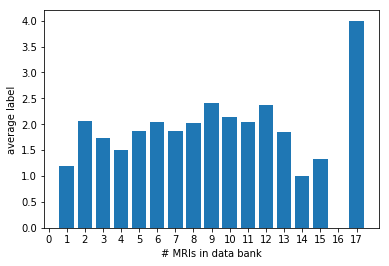

In [54]:
analysis_df = add_no_MRI()[["label", "no_MRI"]].astype({"label": int, "no_MRI": int})
correlation = analysis_df.groupby("no_MRI").mean()

plt.bar(correlation.index, correlation.label)
plt.xticks(np.arange(0,18))
plt.xlabel("# MRIs in data bank")
plt.ylabel("average label")
plt.show()

In [55]:
def split_individuals(file, seed=100):
    """
    takes into account that the MRIs of the same individual should be in the same set
    """
    np.random.seed(seed)
    
    subjects = file_names.subject.unique()
    np.random.shuffle(subjects)
    
    cut = int(subjects.shape[0]/10)
    test, val, train = subjects[:cut], subjects[cut:2*cut], subjects[2*cut:]
    
    test_filter = pd.Series([subject in test for subject in file_names.subject], index=file_names.index)
    testing_file_names = file_names[test_filter] 
    
    val_filter = pd.Series([subject in val for subject in file_names.subject], index=file_names.index)
    validation_file_names = file_names[val_filter] 
    
    train_filter = pd.Series([subject in train for subject in file_names.subject], index=file_names.index)
    training_file_names = file_names[train_filter] 

    return training_file_names, validation_file_names, testing_file_names


training_file_names, validation_file_names, testing_file_names = split_individuals(file_names)
print(training_file_names.shape)
print(validation_file_names.shape)
print(testing_file_names.shape)

(7770, 4)
(960, 4)
(919, 4)


In [56]:
    def split_all(file, random_state=100):
        """
        splits the whole data into train, validation and test set. MRIs from an individual in the training set can end up
        in the test set if the person has multiple MRIs in the data bank
        """
        file_names = file.sample(frac=1, random_state=random_state)
        cut = int(len(file_names)/10)
        
        testing_file_names = file_names[:cut]
        validation_file_names = file_names[cut:2*cut]
        training_file_names = file_names[2*cut:]
        return training_file_names, validation_file_names, testing_file_names

#training_file_names, validation_file_names, testing_file_names = split_all(file_names)
#print(training_file_names.shape)
#print(validation_file_names.shape)
#print(testing_file_names.shape)

Class 0.0 :  2462
Class 1.0 :  983
Class 2.0 :  1424
Class 3.0 :  668
Class 4.0 :  2233
Proportion: 2.5 : 1


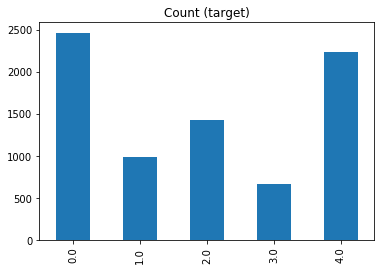

In [57]:
target_count = training_file_names.label.value_counts().sort_index()
df_classes = dict()
for keys, values in target_count.items():
    print('Class', keys, ': ', values)
    df_classes[keys] = training_file_names[training_file_names['label'] == keys]

print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')
plt.show()

In [58]:
# Class count
count_class_0 = training_file_names.label.value_counts()[0]

Random over-sampling:
4    2462
3    2462
2    2462
1    2462
0    2462
Name: label, dtype: int64


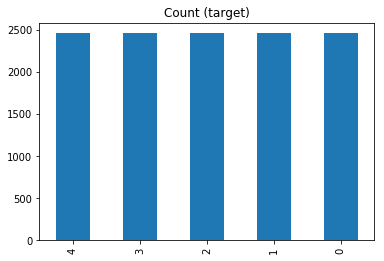

In [59]:
df_classes_over = dict()
training_file_names_over = pd.DataFrame()
for key in df_classes:
    df_classes_over[key]= df_classes[key].sample(count_class_0, replace=True)
    training_file_names_over = pd.concat([training_file_names_over, df_classes_over[key]], axis=0)
#training_file_names_over = pd.concat([df_class_0, df_class_1_over, df_class_2_over, df_class_3_over, df_class_4_over], axis=0)

print('Random over-sampling:')
print(training_file_names_over.label.value_counts())
training_file_names_over.label.value_counts().plot(kind='bar', title='Count (target)')
plt.show()

In [60]:
training_file_names_over = training_file_names_over.sample(frac=1).reset_index(drop=True)
display(training_file_names_over.head())
training_file_names_over.shape

,filename,ind,label,subject
0,141_S_1004_S206890-T1_T1_brain_mni305.nii,141_S_1004_206890,4,141_S_1004
1,094_S_4630_S219809-T1_T1_brain_mni305.nii,094_S_4630_219809,3,094_S_4630
2,130_S_4817_S556877-T1_T1_brain_mni305.nii,130_S_4817_556877,3,130_S_4817
3,141_S_4160_S121753-T1_T1_brain_mni305.nii,141_S_4160_121753,2,141_S_4160
4,094_S_1164_S23871_T1_brain_mni305.nii,094_S_1164_23871,1,094_S_1164


(12310, 4)

In [61]:
if not os.path.exists('../data'):
    os.makedirs('../data')

training_file_names_over.to_csv('../data/training_file_names_over.csv')
testing_file_names.to_csv('../data/testing_file_names.csv')
validation_file_names.to_csv('../data/validation_file_names.csv')

In [62]:
def write_tfrecords(save_filename, file_names, min_, max_):
    '''
    raveling all three dimensions and normalizing every entry
    '''
    i=0
    start_time = time.time()
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        writer = tf.compat.v1.python_io.TFRecordWriter(save_filename)
        for index, row in file_names.iterrows():
            filename = row['filename']
            label = int(row['label'])
            name = str.encode(row['ind'])
            image_ = nib.load(rel_path + filename)
            im = image_.get_data()
            normalized_im = (im.ravel()-min_)/(max_+0.0001-min_)
            feature = {'label': _int64_feature(label),
                   'image': _float_feature(normalized_im),
                     'name': _bytes_feature(name)}
            # Create an example protocol buffer - Protocol buffers are a cross-platform, 
            #    cross-language library for efficient serialization of structured data.
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # Serialize to string and write on the file
            writer.write(example.SerializeToString())
            i+=1
            if i%200==0:
                print('i: ',i)
                print("--- {:.0f} seconds ---".format(time.time() - start_time))
        writer.close()

In [63]:
#write_tfrecords('../data/training_flat_256_3d.tfrecords', training_file_names_over, min_flat, max_flat)
#write_tfrecords('../data/testing_flat_256_3d.tfrecords', testing_file_names, min_flat, max_flat)
#write_tfrecords('../data/validation_flat_256_3d.tfrecords', validation_file_names, min_flat, max_flat)